<a href="https://colab.research.google.com/github/MHoseinHoushmand/Clustering-documents-by-SFLA/blob/main/Clustering_by_SFLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries & prerequisites

In [ ]:
import numpy as np
import pdb
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from numpy.linalg import norm
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
import matplotlib.pyplot as plt
import operator
import random
import pandas as pd
from google.colab import drive
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from sklearn.cluster import KMeans

In [ ]:
#Load pretrained model for gensim word2vec model
drive.mount('/content/drive')
word2Vec_model = Word2Vec.load("/content/drive/MyDrive/word2vec.bin")

Mounted at /content/drive


In [ ]:
#Vectorize documents by feature values using gensim  word2vec model
def docs_as_vector(docs,model):
    docs_vectors = []
    for doc in docs:
       words = doc.split()
       vectors = [model.wv[word] for word in words if word in model.wv]
       if vectors:
          docs_vector = np.mean(vectors, axis=0)
          docs_vectors.append(docs_vector)
    return docs_vectors

In [ ]:
def cosin_sim(a,b):
   return cosine_similarity([a], [b])[0][0]

# BBC text dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/bbc-text.csv")

In [ ]:
# set labels and dataset
texts = list(df.text)[0:200]
labels_tag = list(df.category)[0:200]
labels = []
label_to_number = {'tech': 0, 'business': 1, 'sport': 2, 'entertainment': 3, 'politics': 4}
for label in labels_tag:
    labels.append(label_to_number[label])


200 documents - 5 categories


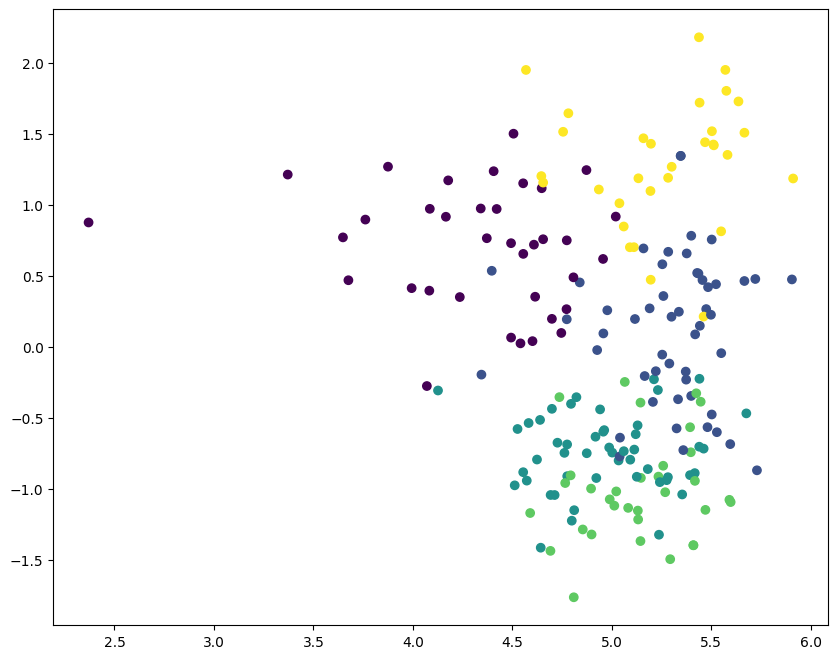

In [ ]:
# plot K-Means clustering by tfidf
kmeans = KMeans(
    n_clusters=5,
    max_iter=100,
    n_init=5,
)
docs_vector = docs_as_vector(texts,word2Vec_model)
kmeans.fit(docs_vector)
labelk =kmeans.labels_
unique_labels, category_sizes = np.unique(labelk, return_counts=True)
true_k = unique_labels.shape[0]
print(f"{len(texts)} documents - {true_k} categories")
lsa = TruncatedSVD(n_components=2)
lsa_matrix = lsa.fit_transform(docs_vector)
plt.figure(figsize=(10, 8))
plt.scatter(lsa_matrix[:, 0], lsa_matrix[:, 1], c=list(labelk), cmap='viridis')

200 documents - 5 categories


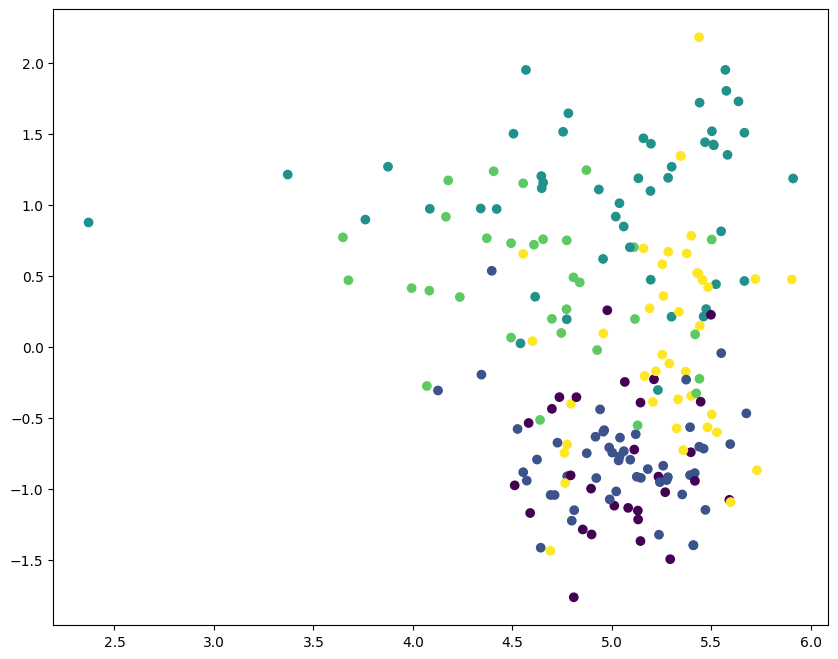

In [ ]:
#plot real labels by tfidf
lsa = TruncatedSVD(n_components=2)
docs_vector = docs_as_vector(texts,word2Vec_model)
true_k = unique_labels.shape[0]
print(f"{len(texts)} documents - {true_k} categories")

tfidf_vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000, stop_words='english')
lsa = TruncatedSVD(n_components=2)
lsa_matrix = lsa.fit_transform(docs_vector)

plt.figure(figsize=(10, 8))
plt.scatter(lsa_matrix[:, 0], lsa_matrix[:, 1], c=list(labels), cmap='viridis')

# 20newsgroup dataset


In [ ]:
categories = [  #Select 4 categories from fetch_20newsgroups dataset
   # "alt.atheism",
    "comp.graphics",
   # "sci.space",
    "rec.sport.hockey",
]
dataset = fetch_20newsgroups( #Preprocessing before using dataset
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)
texts = dataset.data[0:206]
labels = list(dataset.target[0:206])
#Delete Null texts
del texts[16]
del texts[42]
del texts[126]
del texts[137]
del texts[182]
del texts[183]
#Delete Null labels
del labels[16]
del labels[42]
del labels[126]
del labels[137]
del labels[182]
del labels[183]
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]
print(f"{len(texts)} documents - {true_k} categories")

200 documents - 2 categories


200 documents - 2 categories


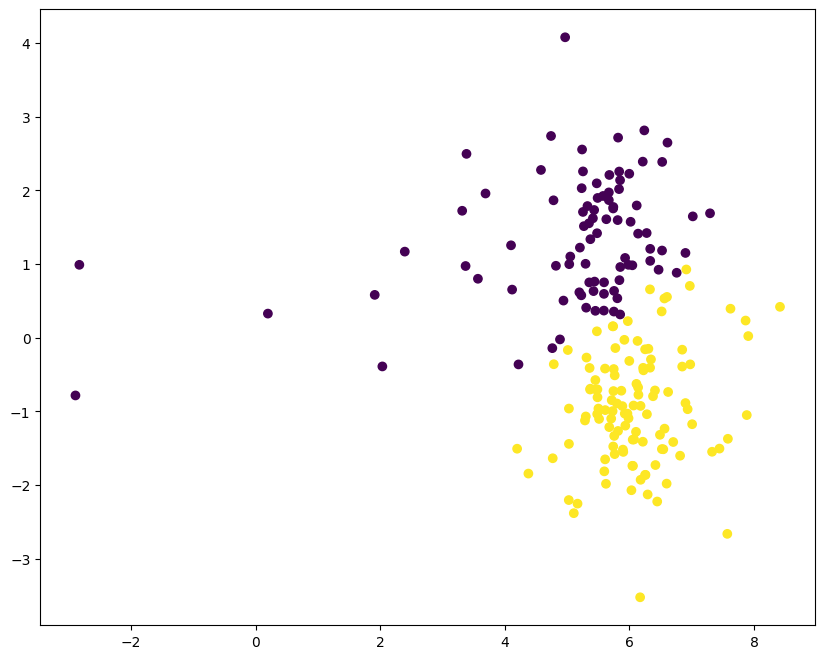

In [ ]:
# plot K-Means clustering by tfidf
kmeans = KMeans(
    n_clusters=2,
    max_iter=100,
    n_init=5,
)
docs_vector = docs_as_vector(texts,word2Vec_model)
kmeans.fit(docs_vector)
labelk =kmeans.labels_
unique_labels, category_sizes = np.unique(labelk, return_counts=True)
true_k = unique_labels.shape[0]
print(f"{len(texts)} documents - {true_k} categories")
lsa = TruncatedSVD(n_components=2)
lsa_matrix = lsa.fit_transform(docs_vector)
plt.figure(figsize=(10, 8))
plt.scatter(lsa_matrix[:, 0], lsa_matrix[:, 1], c=list(labelk), cmap='viridis')

200 documents - 5 categories


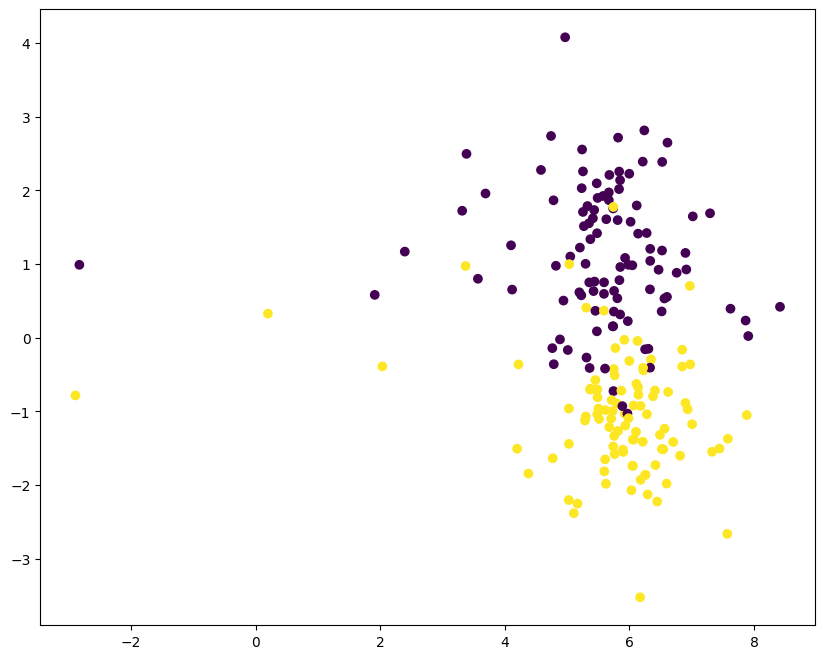

In [ ]:
#plot real labels by tfidf
lsa = TruncatedSVD(n_components=2)
docs_vector = docs_as_vector(texts,word2Vec_model)
true_k = unique_labels.shape[0]
print(f"{len(texts)} documents - {true_k} categories")
lsa_matrix = lsa.fit_transform(docs_vector)
plt.figure(figsize=(10, 8))
plt.scatter(lsa_matrix[:, 0], lsa_matrix[:, 1], c=list(labels), cmap='viridis')

# IMDB reveiw dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")

In [ ]:
texts = list(df.review)[0:200]
labels_tag = list(df.sentiment)[0:200]
labels = []
label_to_number = {'negative': 0, 'positive': 1}
for label in labels_tag:
    labels.append(label_to_number[label])

200 documents - 2 categories


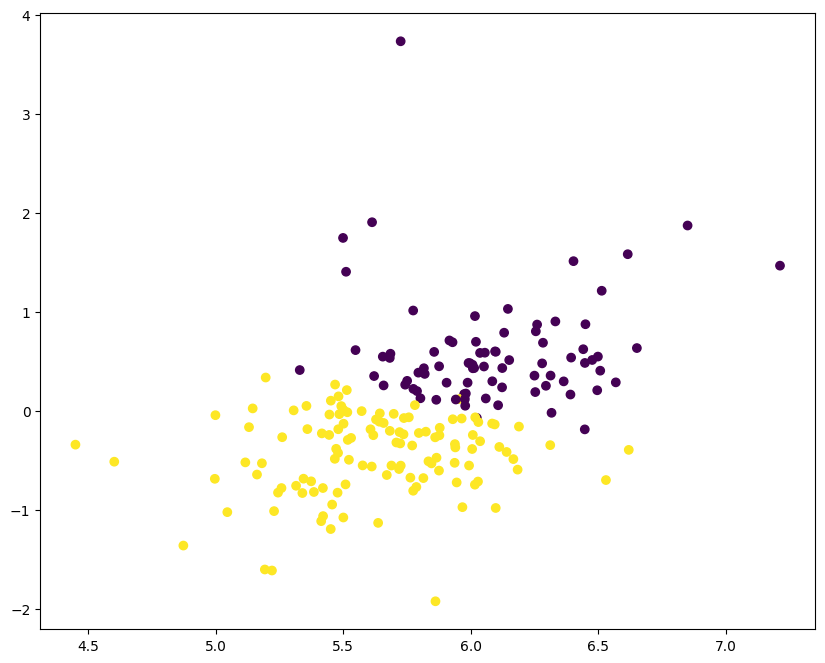

In [ ]:
kmeans = KMeans(
    n_clusters=2,
    max_iter=100,
    n_init=5,
)
docs_vector = docs_as_vector(texts,word2Vec_model)
kmeans.fit(docs_vector)
labelk =kmeans.labels_
unique_labels, category_sizes = np.unique(labelk, return_counts=True)
true_k = unique_labels.shape[0]
print(f"{len(texts)} documents - {true_k} categories")
lsa = TruncatedSVD(n_components=2)
lsa_matrix = lsa.fit_transform(docs_vector)
plt.figure(figsize=(10, 8))
plt.scatter(lsa_matrix[:, 0], lsa_matrix[:, 1], c=list(labelk), cmap='viridis')

200 documents - 2 categories


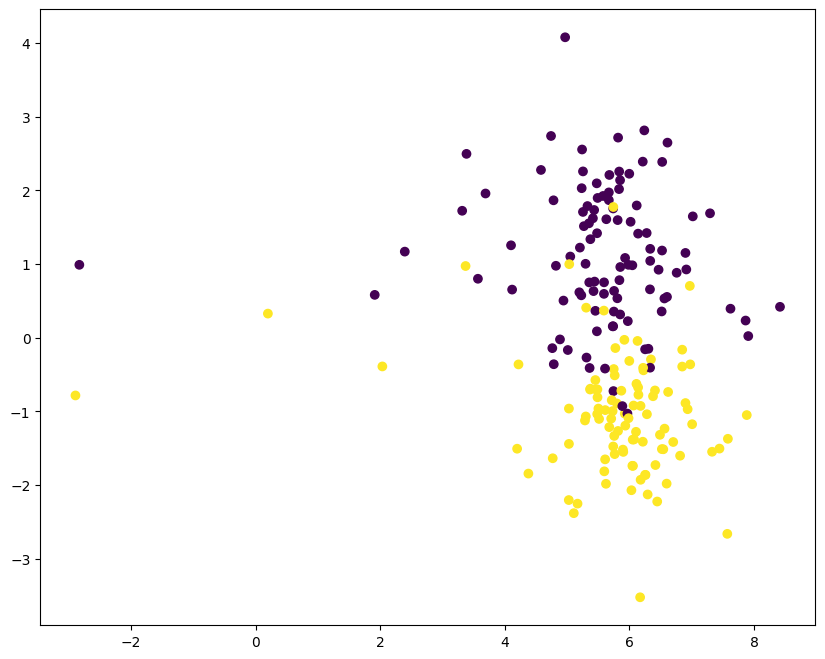

In [ ]:
lsa = TruncatedSVD(n_components=2)
docs_vector = docs_as_vector(texts,word2Vec_model)
true_k = unique_labels.shape[0]
print(f"{len(texts)} documents - {true_k} categories")

tfidf_vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000, stop_words='english')
lsa = TruncatedSVD(n_components=2)
lsa_matrix = lsa.fit_transform(docs_vector)

plt.figure(figsize=(10, 8))
plt.scatter(lsa_matrix[:, 0], lsa_matrix[:, 1], c=list(labels), cmap='viridis')

# Train word2vec model

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/bbc-text.csv")
texts = list(df.text)


In [ ]:
categories = [  #Select 4 categories from fetch_20newsgroups dataset
 'alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc'
]
dataset = fetch_20newsgroups( #Preprocessing before using dataset
    remove=("headers", "footers", "quotes"),
    subset="all",
    categories=categories,
    shuffle=True,
    random_state=42,
)
texts = texts + dataset.data


In [ ]:
def docs_as_token(texts):
   output =[]
   for text in texts:
       tokens = text.lower().split()
       output.append(tokens)
   return output

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/bbc-text.csv")
texts = texts + dataset.data

In [ ]:
docs_token = docs_as_token(texts)
word2vec_model = Word2Vec(docs_token, min_count=5,
                          vector_size=150, window=7)



In [ ]:
word2vec_model.save("/content/drive/MyDrive/word2vec2.bin")



# Define Objects

In [ ]:
class Cluster:
     def __init__(self):
         self.documents = []
         self.doc_mean = []

     def get_doc_mean(self):
        self.doc_mean = np.average(self.documents, axis=0)
        return self.doc_mean

     def SSE(self):     #Sum of squared error(SSE) as similarity of each documents with the cluster mean in document
         doc_mean = self.get_doc_mean()
         size = len(self.documents)
         sse=0
         for doc in self.documents:
             sse += cosin_sim(doc,doc_mean)**2
         try:
             sse = sse/size
         except ZeroDivisionError:
             return 0
         return sse


In [ ]:
class Frog:
     def __init__(self,answer,docs_vector,n_clusters):
        self.answer = answer
        self.value = self.fitness(docs_vector,n_clusters)



     def build_clusters(self,docs_vector,n_clusters):#Build clusters for frog
          clusters = []
          for i in range(n_clusters):
             cluster = Cluster()
             clusters.append(cluster)
          for j in range(len(self.answer)):
             if -1 < self.answer[j]:
                clusters[self.answer[j]].documents.append(docs_vector[j])
          return clusters


     def WC(self,clusters):   #Calculate similarity within clusters
        WC = 0
        for cluster in clusters:
            WC += cluster.SSE()
        return WC


     def BC(self,doc_means):#Calculate similarity between clusters
          BC=0
          size = len(doc_means)
          for i in range(size):
              for j in range(i+1,size):
                  BC += cosin_sim(doc_means[i],doc_means[j])**2
          return BC


     def fitness(self,docs_vector,n_clusters):
           doc_means = []
          # pdb.set_trace()
           clusters = self.build_clusters(docs_vector,n_clusters)
           for i in range(n_clusters):
               doc_means.append(
                  clusters[i].get_doc_mean()
               )
           wc = self.WC(clusters) #Calculate similarity within clusters
           bc = self.BC(doc_means) #Calculate similarity between clusters
           fitness = wc/bc
           return fitness


     def cross_over(self,frog_b,docs_vector,n_clusters): #perform 2 points cross over
           frog_size = len(self.answer)
           points = sorted(np.random.choice(np.arange(0,frog_size), size=2, replace=False))
           answer1 = self.answer[:points[0]] + frog_b.answer[points[0]:points[1]] + self.answer[points[1]:]
           answer2 = frog_b.answer[:points[0]] + self.answer[points[0]:points[1]] + frog_b.answer[points[1]:]
           child1 = Frog(answer1,docs_vector,n_clusters)
           child2 = Frog(answer2,docs_vector,n_clusters)
           if child1.value > child2.value: # return best child
               return child1
           else :
               return child2

     def mutation(self,docs_vector,n_clusters):#Select len(answer)/4 of answers and change value
         new_ans = list(self.answer)
         size = int(len(self.answer)/4)
         indexes = np.random.choice(np.arange(0,len(self.answer)), size=size, replace=False)#Select indexes for changing
         values= [random.randint(0, n_clusters-1) for _ in range(size)]
         for i in range(size):
            new_ans[indexes[i]] = values[i]
         child = Frog(tuple(new_ans),docs_vector,n_clusters)
         return  child

In [ ]:
class Memplex:
     def __init__(self):
         self.frogs = []

     def best(self):
        if len(self.frogs) > 0:
           return self.frogs[0]

     def worst(self,frogs):
        if len(self.frogs) > 0:
           return self.frogs[len(self.frogs)-1]

     def frogs_to_remove(self,sub_memplex):#Remove all frogs from submemplex in memplex
         for item in sub_memplex.frogs:
            self.frogs.remove(item)
         return self

     def add_frogs(self,submemplex):
         self.frogs = self.frogs + submemplex.frogs


In [ ]:
class Submemplex:
     def __init__(self, memplex ,n_submemplex,memplex_size ):#Creating submemplex by Trigonometric probability
         self.frogs = []
         self.prob_list = []
         indexs = []
         for i in range(memplex_size):
             for j in range(2*(memplex_size-i)):
                 self.prob_list.append(i)
         k=0
         while(k!=n_submemplex):
            index = random.choice(self.prob_list)
            key = memplex.frogs[index].answer
           # pdb.set_trace()
            if index not in indexs:
                self.frogs.append(memplex.frogs[index])
                indexs.append(index)
                k+=1

     def best(self):
         local_best =  max(self.frogs, key=lambda frog: frog.value)
         return local_best

     def worst(self):
         local_worst =  min(self.frogs, key=lambda frog: frog.value)
         return local_worst

In [ ]:
class Population:
     def __init__(self,n_clusters, n_population ,n_docs, docs_vector):
        answers = np.random.randint(0, n_clusters, size=(n_population , n_docs))
        self.frogs = []
        print("Frogs Initialization ...")
        for answer in answers:
           frog = Frog(tuple(answer),docs_vector,n_clusters)
           self.frogs.append(frog)


     def clear_frogs(self):
        self.frogs.clear()

     def global_best(self,memplexes):#Return best frog of all memplexes
        local_bests = []
        for memplex in memplexes:
            local_best =  max(memplex.frogs, key=lambda frog: frog.value)
            local_bests.append(local_best)
        global_best =  max(local_bests, key=lambda frog: frog.value)
        return global_best

     def shufeling(self,memplexes):#Shufle memplexes and recreate population
         output = []
         for memplex in memplexes:
            output = output+ memplex.frogs
         self.frogs = output

In [ ]:
class SFLA:
     def  __init__(self,n_clusters, max_iteration, texts ,labels,model):
        self.n_clusters = n_clusters
        self.max_iteration =  max_iteration
        self.docs = texts
        self.n_population = 400 # Frogs number
        self.memplex_size = 20 #define as m
        self.n_memplex = 20 #define as n
        self.local_iteration = 10 #Iteration As local search
        self.n_submemplex = 5
        self.docs_vector = docs_as_vector(self.docs,model)  #Convert documents as feature values
        self.n_docs = len(self.docs)
        self.labels = labels


     def create_memplexes(self,population,n_memplex):#ّFrogs are distributed fairly in the memplexes
             population = sorted(population.frogs, key=lambda frog: frog.value)
             memplexes = []
             for i in range(n_memplex):
                 memplex = Memplex()
                 memplexes.append(memplex)
             for i in range(self.n_population):
                 memplexes[i % n_memplex].frogs.append(population[i])
             return memplexes

     def plot_frog(self, frog):
        lsa = TruncatedSVD(n_components=2)
        lsa_matrix = lsa.fit_transform(self.docs_vector)
        labels = frog.answer
        unique_labels, category_sizes = np.unique(labels, return_counts=True)
        true_k = unique_labels.shape[0]
        lsa = TruncatedSVD(n_components=2)
        plt.figure(figsize=(10, 8))
        plt.scatter(lsa_matrix[:, 0], lsa_matrix[:, 1], c=list(labels), cmap='viridis')

     def evaluation(self ,frog) :
          homogeneity_score = metrics.homogeneity_score(self.labels, frog.value)
          completeness_score = metrics.completeness_score(self.labels, frog.value)
          v_measure_score = metrics.v_measure_score(self.labels, frog.value)
          accuracy_score = metrics.accuracy_score(self.labels, frog.value)
          print("homogeneity_score: " , homogeneity_score)
          print("completeness_score: ", completeness_score)
          print("v_measure_score: " , v_measure_score)
          print("accuracy_score: " , accuracy_score)




     def search(self):
        population = Population(self.n_clusters, self.n_population, self.n_docs, self.docs_vector)
        for i in range(self.max_iteration):
           print("Epoch: ", i)
           memplexes = self.create_memplexes(population,self.n_memplex)
           population.clear_frogs()
           for j in range(self.n_memplex):
               submemplex = Submemplex(memplexes[j],self.n_submemplex,self.memplex_size)
               memplexes[j].frogs_to_remove(submemplex)
               for k in range(self.local_iteration):
                    lfrog_best = submemplex.best()
                    lfrog_worst = submemplex.worst()
                    frog_out = lfrog_worst.cross_over(lfrog_best, self.docs_vector, self.n_clusters)
                    if (lfrog_worst.value < frog_out.value ):
                         submemplex.frogs.remove(lfrog_worst)
                         submemplex.frogs.append(frog_out)
                    else:
                         gfrog_best = population.global_best(memplexes)
                         frog_out = gfrog_best.cross_over(lfrog_worst, self.docs_vector, self.n_clusters)
                         if (lfrog_worst.value<frog_out.value):
                                      submemplex.frogs.remove(lfrog_worst)
                                      submemplex.frogs.append(frog_out)
                         else:
                                      frog_out = gfrog_best.mutation(self.docs_vector,self.n_clusters)
                                      submemplex.frogs.remove(lfrog_worst)
                                      submemplex.frogs.append(frog_out)
               memplexes[j].add_frogs(submemplex)
           gfrog_best = population.global_best(memplexes)
           print("Best frog in epoch: ", gfrog_best.answer)
           print("Best frog fitness: ",gfrog_best.value)
           population.shufeling(memplexes)
        return gfrog_best

# Test code

Frogs Initialization ...
Epoch:  0
Best frog in epoch:  (1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0)
Best frog fitness:  1.5031094400243041
Epoch:  1
Best frog in epoch:  (1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,

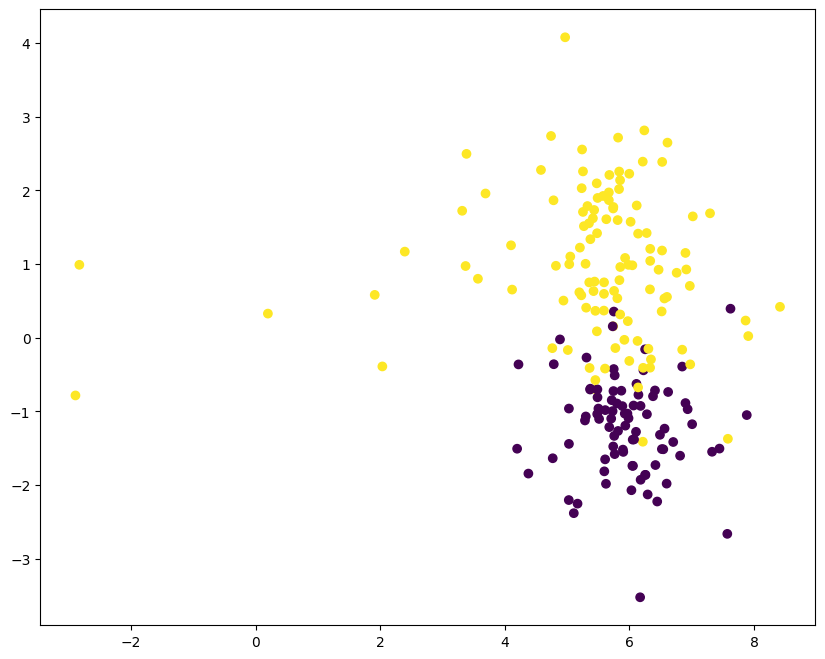

In [ ]:
sfla = SFLA(2,50,texts,labels,word2Vec_model)
best_frog = sfla.search()
sfla.plot_frog(best_frog)